<a href="https://colab.research.google.com/github/milvus-io/bootcamp/blob/master/integration/langchain/agentic_rag_with_milvus_and_langgraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>   <a href="https://github.com/milvus-io/bootcamp/blob/master/integration/langchain/agentic_rag_with_milvus_and_langgraph.ipynb" target="_blank">
    <img src="https://img.shields.io/badge/View%20on%20GitHub-555555?style=flat&logo=github&logoColor=white" alt="GitHub Repository"/>
</a>

# Agentic RAG with Milvus and LangGraph

![](../../pics/agentic_rag_with_langgraph_architecture.png)

This guide demonstrates how to build an advanced Retrieval-Augmented Generation (RAG) system using LangGraph and Milvus. Unlike traditional RAG systems that simply retrieve and generate, agentic RAG systems can make intelligent decisions about when to retrieve information, how to handle irrelevant documents, and when to rewrite queries for better results.

[LangGraph](https://langchain-ai.github.io/langgraph/) is a library for building stateful, multi-actor applications with LLMs, built on top of LangChain. [Milvus](https://milvus.io/) is the world's most advanced open-source vector database, built to power embedding similarity search and AI applications.

In this tutorial, we will build an agentic RAG system that can:
- Decide whether to retrieve documents or respond directly to simple queries
- Grade retrieved documents for relevance
- Rewrite questions when retrieved documents are not relevant
- Generate high-quality answers based on relevant context

## Prerequisites

Before running this notebook, make sure you have the following dependencies installed:

In [ ]:
! pip install --upgrade langchain langchain-core langchain-community langchain-text-splitters langgraph langchain-milvus milvus-lite langchain-openai bs4

> If you are using Google Colab, to enable dependencies just installed, you may need to **restart the runtime** (click on the "Runtime" menu at the top of the screen, and select "Restart session" from the dropdown menu).

We will use the models from OpenAI. You should prepare the [api key](https://platform.openai.com/docs/quickstart) `OPENAI_API_KEY` as an environment variable.

In [ ]:
import os

os.environ["OPENAI_API_KEY"] = "sk-***********"

## Prepare the data

We use the Langchain [WebBaseLoader](https://python.langchain.com/docs/integrations/document_loaders/web_base/) to load documents from [Lilian Weng's blog posts](https://lilianweng.github.io/) and split them into chunks using the [RecursiveCharacterTextSplitter](https://python.langchain.com/docs/how_to/recursive_text_splitter/).

In [3]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Load blog posts about AI topics
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Load documents
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split documents into chunks
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=200
)
doc_splits = text_splitter.split_documents(docs_list)

# Let's see how many document chunks we have
print(f"Total document chunks: {len(doc_splits)}")

USER_AGENT environment variable not set, consider setting it to identify your requests.


Total document chunks: 47


## Create a retriever tool with Milvus

Now we'll create a vector store using Milvus to index our document chunks and create a retriever tool that our agent can use.

In [19]:
from langchain_milvus import Milvus
from langchain_openai import OpenAIEmbeddings
from langchain.tools.retriever import create_retriever_tool

# Initialize embeddings
embeddings = OpenAIEmbeddings()

# Create Milvus vector store
vectorstore = Milvus.from_documents(
    documents=doc_splits,
    embedding=embeddings,
    connection_args={
        "uri": "./milvus_agentic_rag.db",
    },
    drop_old=True,
)

# Create retriever
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

# Create retriever tool
retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about AI agents, prompt engineering, and adversarial attacks on LLMs from Lilian Weng's blog posts.",
)

# Test the retriever tool
print(retriever_tool.invoke({"query": "What is Tree of Thought strategy?"})[:1000])

2025-10-23 15:03:26,670 [DEBUG][_create_connection]: Created new connection using: 0591f8d30be84e7e9b12ad3fc2a63650 (async_milvus_client.py:599)


How Self-Ask works with external search queries.(Image source: Press et al. 2022).


Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, essentially creating a tree structure. The search process can be BFS or DFS while each state is evaluated by a classifier (via a prompt) or majority vote.



How Self-Ask works with external search queries.(Image source: Yao et al. 2022).

Automatic Prompt Design#
Prompt is a sequence of prefix tokens that increase the probability of getting  desired output given input. Therefore we can treat them as trainable parameters and optimize them directly on the embedding space via gradient descent, such as AutoPrompt (Shin et al., 2020, Prefix-Tuning (Li & Liang (2021)), P-tuning (Liu et al. 2021) and Prompt-Tuning (Lester et al. 2021). This section in my “Controllable Neural Text Generation” post has a 

> For the `connection_args`:
> - Setting the `uri` as a local file, e.g.`./milvus_agentic_rag.db`, is the most convenient method, as it automatically utilizes [Milvus Lite](https://milvus.io/docs/milvus_lite.md) to store all data in this file.
> - If you have large scale of data, you can set up a more performant Milvus server on [docker or kubernetes](https://milvus.io/docs/quickstart.md). In this setup, please use the server uri, e.g.`http://localhost:19530`, as your `uri`.
> - If you want to use [Zilliz Cloud](https://zilliz.com/cloud), the fully managed cloud service for Milvus, adjust the `uri` and `token`, which correspond to the [Public Endpoint and Api key](https://docs.zilliz.com/docs/on-zilliz-cloud-console#free-cluster-details) in Zilliz Cloud.

## Build the agentic RAG graph

### Define the graph state

We'll use LangGraph's `MessagesState` which maintains a list of messages in the conversation.

In [5]:
from langgraph.graph import MessagesState
from langchain_openai import ChatOpenAI

# Initialize the language model
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

### Node 1: Generate query or respond

This node decides whether to use the retriever tool to search for information or respond directly to the user.

In [6]:
def generate_query_or_respond(state: MessagesState):
    """
    Decide whether to retrieve information or respond directly.

    Args:
        state: Current graph state with messages

    Returns:
        Updated state with the model's response
    """
    response = llm.bind_tools([retriever_tool]).invoke(state["messages"])
    return {"messages": [response]}


# Test with a simple greeting
test_state = {"messages": [{"role": "user", "content": "Hello!"}]}
result = generate_query_or_respond(test_state)
print("Response to greeting:", result["messages"][-1].content)

# Test with a question that needs retrieval
test_state = {
    "messages": [
        {
            "role": "user",
            "content": "What is Chain of Thought prompting and how does it work?",
        }
    ]
}
result = generate_query_or_respond(test_state)
if hasattr(result["messages"][-1], "tool_calls") and result["messages"][-1].tool_calls:
    print("Model decided to use retrieval tool")
    print("Tool call:", result["messages"][-1].tool_calls[0])

Response to greeting: Hello! How can I assist you today?
Model decided to use retrieval tool
Tool call: {'name': 'retrieve_blog_posts', 'args': {'query': 'Chain of Thought prompting'}, 'id': 'call_UI804LXgqZ3Y7qFvdsWFuKZH', 'type': 'tool_call'}


### Node 2: Grade documents

This node evaluates whether the retrieved documents are relevant to the user's question.

In [7]:
from pydantic import BaseModel, Field
from typing import Literal


class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


def grade_documents(state: MessagesState) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state: Current graph state with messages

    Returns:
        Decision to generate answer or rewrite question
    """
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")

    # Get the question and retrieved documents
    question = state["messages"][0].content
    docs = state["messages"][-1].content

    # Create structured LLM grader
    structured_llm_grader = llm.with_structured_output(GradeDocuments)

    # Grade prompt
    grade_prompt = f"""You are a grader assessing relevance of a retrieved document to a user question.
    
    Retrieved document:
    {docs}
    
    User question:
    {question}
    
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant.
    Give a binary score 'yes' or 'no' to indicate whether the document is relevant to the question."""

    score = structured_llm_grader.invoke(
        [{"role": "user", "content": grade_prompt}]
    ).binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"
    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        return "rewrite"

### Node 3: Rewrite question

If documents are not relevant, this node rewrites the question to improve retrieval results.

In [8]:
def rewrite_question(state: MessagesState):
    """
    Transform the query to produce a better question.

    Args:
        state: Current graph state with messages

    Returns:
        Updated state with rewritten question
    """
    print("---TRANSFORM QUERY---")

    question = state["messages"][0].content

    rewrite_prompt = f"""You are an expert at query expansion and transformation.
    
    Look at the input question and try to reason about the underlying semantic intent / meaning.
    
    Here is the initial question:
    {question}
    
    Formulate an improved question that will retrieve better documents from a vector database:"""

    response = llm.invoke([{"role": "user", "content": rewrite_prompt}])

    return {"messages": [{"role": "user", "content": response.content}]}

### Node 4: Generate answer

This node generates the final answer based on the retrieved relevant documents.

In [9]:
def generate(state: MessagesState):
    """
    Generate answer based on retrieved documents.

    Args:
        state: Current graph state with messages

    Returns:
        Updated state with generated answer
    """
    print("---GENERATE ANSWER---")

    question = state["messages"][0].content
    docs = state["messages"][-1].content

    # RAG generation prompt
    rag_prompt = f"""You are an assistant for question-answering tasks.
    
    Use the following pieces of retrieved context to answer the question.
    
    If you don't know the answer, just say that you don't know.
    
    Use three sentences maximum and keep the answer concise.
    
    Question: {question}
    
    Context: {docs}
    
    Answer:"""

    response = llm.invoke([{"role": "user", "content": rag_prompt}])

    return {"messages": [response]}

### Assemble the graph

Now we'll connect all the nodes together to create our agentic RAG workflow.

In [10]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

# Create the graph
workflow = StateGraph(MessagesState)

# Add nodes
workflow.add_node("generate_query_or_respond", generate_query_or_respond)
workflow.add_node("retrieve", ToolNode([retriever_tool]))
workflow.add_node("rewrite", rewrite_question)
workflow.add_node("generate", generate)

# Add edges
workflow.add_edge(START, "generate_query_or_respond")

# Conditional edge: decide whether to retrieve or end
workflow.add_conditional_edges(
    "generate_query_or_respond",
    tools_condition,
    {
        "tools": "retrieve",  # If tool call, go to retrieve
        END: END,  # If no tool call, end (direct response)
    },
)

# Conditional edge: grade documents
workflow.add_conditional_edges(
    "retrieve",
    grade_documents,
    {
        "generate": "generate",  # If relevant, generate answer
        "rewrite": "rewrite",  # If not relevant, rewrite question
    },
)

# After rewriting, try to generate query again
workflow.add_edge("rewrite", "generate_query_or_respond")

# After generating answer, end
workflow.add_edge("generate", END)

# Compile the graph
graph = workflow.compile()

Let's visualize the graph structure to understand the workflow:

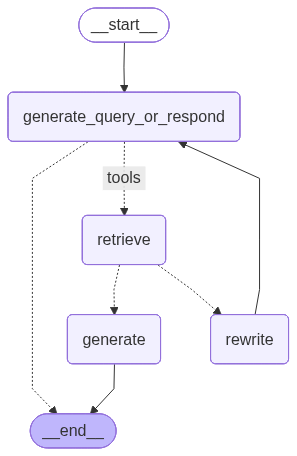

In [11]:
from IPython.display import Image, display

# Visualize the graph
display(Image(graph.get_graph().draw_mermaid_png()))

## Run the agentic RAG system

Now let's test our agentic RAG system with different types of queries.

### Test 1: Simple greeting (no retrieval needed)

In [12]:
inputs = {"messages": [{"role": "user", "content": "Hello! How are you?"}]}

print("=" * 50)
print("Test 1: Simple greeting")
print("=" * 50)

for output in graph.stream(inputs):
    for key, value in output.items():
        print(f"Node '{key}':")
        if "messages" in value:
            value["messages"][-1].pretty_print()
    print("\n")

Test 1: Simple greeting
Node 'generate_query_or_respond':
================================== Ai Message ==================================

Hello! I'm just a program, so I don't have feelings, but I'm here and ready to help you. How can I assist you today?




### Test 2: Question requiring retrieval

In [13]:
inputs = {
    "messages": [
        {
            "role": "user",
            "content": "What are the main components and building blocks of an AI agent system?",
        }
    ]
}

print("=" * 50)
print("Test 2: Question requiring retrieval")
print("=" * 50)

for output in graph.stream(inputs):
    for key, value in output.items():
        print(f"Node '{key}':")
        if "messages" in value:
            print(value["messages"][-1])
    print("-" * 50)

Test 2: Question requiring retrieval
Node 'generate_query_or_respond':
content='' additional_kwargs={'tool_calls': [{'id': 'call_HJXekNMWmnlgp9EcJlD5Tpvk', 'function': {'arguments': '{"query":"AI agent system components building blocks"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 89, 'total_tokens': 109, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CTjEx6R7mmeyEBX9EnOSlUGtvPL9L', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--954ed7ac-d780-4c7d-925f-3ffe959804b9-0' tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'AI agent system components building blocks'}, 'id': 'call_HJXekNMW

### Test 3: Question that might trigger rewrite

In [14]:
inputs = {
    "messages": [
        {
            "role": "user",
            "content": "How do we defend against potential risks in AI systems?",
        }
    ]
}

print("=" * 50)
print("Test 3: Question that might need rewriting")
print("=" * 50)

for output in graph.stream(inputs):
    for key, value in output.items():
        print(f"Node '{key}':")
        if "messages" in value:
            print(value["messages"][-1])
    print("-" * 50)

Test 3: Question that might need rewriting
Node 'generate_query_or_respond':
content='' additional_kwargs={'tool_calls': [{'id': 'call_9N22LV1M3IGDR8t3DaWplR0n', 'function': {'arguments': '{"query":"defend against risks in AI systems"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 86, 'total_tokens': 107, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CTjF3askTBa5upgmWx2ftdwogs6JU', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--1dcefc0d-acb2-4771-8b27-484a56ab32be-0' tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'defend against risks in AI systems'}, 'id': 'call_9N22LV1M3IGDR8t3Da

## Summary

In this tutorial, we built an agentic RAG system using LangGraph and Milvus that can intelligently decide when to retrieve information, evaluate document relevance, and rewrite queries for better results. This approach provides significant advantages over traditional RAG systems, including better user experience through intelligent routing, higher quality answers with document grading, and improved retrieval through query rewriting. You can extend this system further by adding more sophisticated grading logic, implementing multiple retrieval strategies, or incorporating additional tools and data sources.